# Gaussian Mixture Analysis for clustering

In [1]:
import numpy as np
from sklearn.mixture import GaussianMixture
import rasterio
import pandas as pd
import os
import sys
import argparse 
import multiprocessing as mp
import tqdm
from matplotlib import pyplot as plt
import random

In [2]:
print('----------------------------------------------------------')
print('Population data process 5/7: clustering popluation weights')
print('----------------------------------------------------------')

----------------------------------------------------------
Population data process 5/7: clustering popluation weights
----------------------------------------------------------


In [3]:
#setting up paths for files
#top_folder="/home/dohyungkim/population"
#ISO="PER"
#year="2015"

In [ ]:
# Initialize parser 
my_parser = argparse.ArgumentParser(description='initial input')
my_parser.add_argument('top_folder',metavar='top_folder',type=str,help='working folder')
my_parser.add_argument('ISO',metavar='ISO',type=str,help='3 character country iso code')
my_parser.add_argument('year',metavar='year',type=str,help='population year')
args = my_parser.parse_args()
top_folder = args.top_folder
ISO = args.ISO
year = args.year
if not os.path.isdir(top_folder):
    print('The path specified does not exist')
    sys.exit()

In [4]:
fb_path=os.path.join(top_folder,ISO,"fb_data")
wp_path=os.path.join(top_folder,ISO,"wp_data")

In [5]:
fb_file=os.path.join(fb_path,'out_tiles', "fb_weight.vrt") #weight file from worldpop script

In [6]:
fb_img=rasterio.open(fb_file)
transform=fb_img.transform

In [7]:
fb_arr=fb_img.read(1)
shape=fb_arr.shape

In [8]:
fb_arr=fb_arr.reshape(-1, 1)

In [9]:
shape2=fb_arr.shape

In [10]:
select=np.where(~np.isnan(fb_arr))
select_arr=fb_arr[select]

In [11]:
#select_arr=select_arr.reshape(-1, 1)

In [12]:
del fb_arr

In [13]:
np.random.seed(0)
x_arr=np.random.choice(select_arr,100000)
x_arr=x_arr.reshape(-1, 1)

In [14]:
def gmm(n_comp):
    model=GaussianMixture(n_comp, covariance_type='full', random_state=0).fit(x_arr)
    return model

In [15]:
n_components = np.arange(1,100)
number_processes = 5
p = mp.Pool(number_processes)
models = list(tqdm.tqdm(p.map(gmm, n_components), total=len(n_components)))
p.close()
p.join()

100%|██████████| 99/99 [01:21<00:00,  1.21it/s]


In [16]:
def bic(model):
    bic=model.bic(x_arr)
    return bic

In [17]:
def aic(model):
    aic=model.aic(x_arr)
    return aic

In [18]:
p = mp.Pool()
aics = list(tqdm.tqdm(p.map(aic, models), total=len(models)))
p.close()
p.join()

100%|██████████| 99/99 [00:10<00:00,  9.55it/s]


In [19]:
p = mp.Pool()
bics = list(tqdm.tqdm(p.map(bic, models), total=len(models)))
p.close()
p.join()

100%|██████████| 99/99 [00:10<00:00,  9.81it/s]


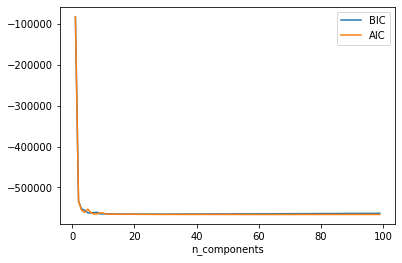

In [20]:
plt.plot(n_components, bics, label='BIC')
plt.plot(n_components, aics, label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');
plt.savefig(os.path.join(top_folder,ISO,"gmm.png"), dpi=100)

In [23]:
min_bic=n_components[np.argmin(bics)]
min_aic=n_components[np.argmin(aics)]
print("minimum aic at:"+str(min_aic))
print("minimum bic at:"+str(min_bic))
n_component=np.min([min_aic, min_bic])

minimum aic at:56
minimum bic at:21


In [24]:
clf=models[n_component-1]

In [25]:
means_init=np.argsort(clf.means_, axis=0)

In [26]:
predict=clf.predict(select_arr.reshape(-1, 1))
predict_org=predict.copy()

In [27]:
for i in range(len(means_init)):
    predict[np.where(predict_org==means_init[i][0])]=i

In [28]:
#mean, min, max values of weighting layer
arr_max=np.zeros(len(clf.means_))
arr_min=np.zeros(len(clf.means_))
arr_mean=np.sort([x[0] for x in clf.means_])

In [29]:
for i in range(len(clf.means_)):
    arr_max[i]=np.max(select_arr[np.where(predict==i)])
    arr_mean[i]=np.mean(select_arr[np.where(predict==i)])
    arr_min[i]=np.min(select_arr[np.where(predict==i)])

In [30]:
del select_arr

In [31]:
df_bnd=pd.DataFrame([arr_mean,arr_min,arr_max]).transpose()
df_bnd.columns=['mean', 'min', 'max']
df_bnd.to_pickle(os.path.join(wp_path,"df_bnd.pkl"))

In [32]:
predict=predict+1

In [33]:
fb_arr = np.ndarray(shape=shape2, dtype=np.uint8)

In [34]:
fb_arr[select] = predict

In [35]:
fb_arr=fb_arr.reshape(shape)

In [36]:
print('clustering finished..saving clusters as a tif file')

clustering finished..saving clusters as a tif file


In [37]:
with rasterio.open(os.path.join(wp_path,'fb_weight_gmm.tif'),
                   'w', 
                   driver='GTiff',
                   height=shape[0],
                   width=shape[1],
                   count=1,
                   dtype=fb_arr.dtype,
                   crs='+proj=latlong',
                   transform=transform,
                   compress='lzw'
) as dst:
    dst.write(fb_arr, 1)

In [38]:
df_info=pd.read_pickle(os.path.join(top_folder,ISO,"df_info.pkl"))
df_info["n_component"]=n_component
df_info.to_pickle(os.path.join(top_folder,ISO,"df_info.pkl"))